# <div style="text-align: center;"> **XGBOOST MODELS** </div>

--------------

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_loader import LoadImage
from image_preprocesser import preprocess_image, apply_preprocessing
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, establish_checkpoints , train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix, plot_auc_curve
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2025-02-25 08:59:13.274606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740470353.295574  909128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740470353.300259  909128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 08:59:13.319146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [4]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [5]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### **Pretrained network VGG16**

In [8]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

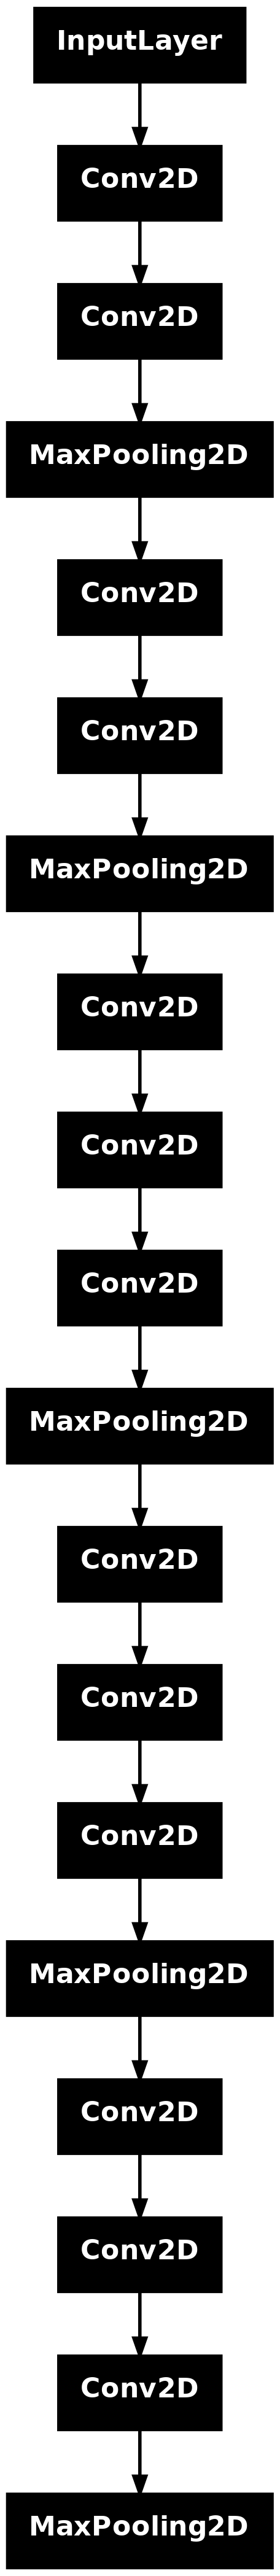

In [9]:
tf.keras.utils.plot_model(conv_base_VGG16)

In [10]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [11]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

I0000 00:00:1740470637.267116  948335 service.cc:148] XLA service 0x7fbc3c004cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740470637.267142  948335 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-02-25 09:03:57.289313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740470637.342286  948335 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-25 09:03:57.634398: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

In [12]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

*By default XGB model*

In [16]:
num_classes = len(np.unique(train_labels))

xgb = XGBClassifier(booster = 'gbtree', eta = 0.1, gamma = 0.1, max_depth = 4, min_child_weight = 100, subsample = 1.0, colsample_bytree = 0.8, reg_lambda = 0.01, 
              alpha = 0.01, tree_method = "hist", objective = "multi:softmax", num_class=num_classes)

xgb.fit(train_features, np.ravel(train_labels))


XGBClassifier(alpha=0.01, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=100, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

Accuracy in test: 0.7796610169491526
              precision    recall  f1-score   support

         0.0       0.97      0.58      0.73       387
         1.0       0.70      0.98      0.81       380

    accuracy                           0.78       767
   macro avg       0.83      0.78      0.77       767
weighted avg       0.83      0.78      0.77       767



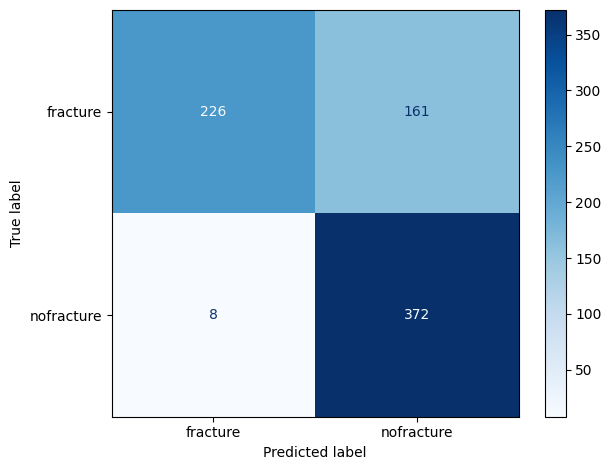

In [17]:
#Evaluating the model
test_predictions = xgb.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.9184


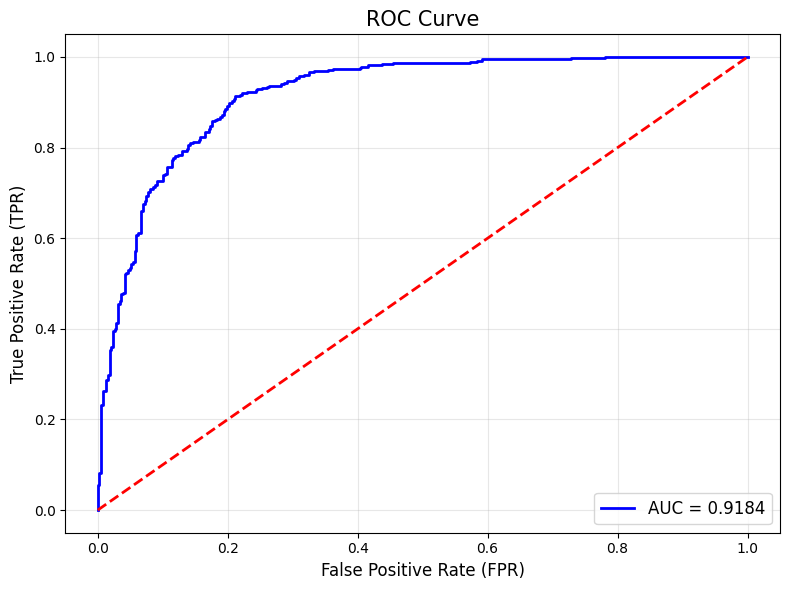

In [18]:
#Obtaining probability for positive class (1)
test_probabilities = xgb.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

----------------

*Changing class probabilities*